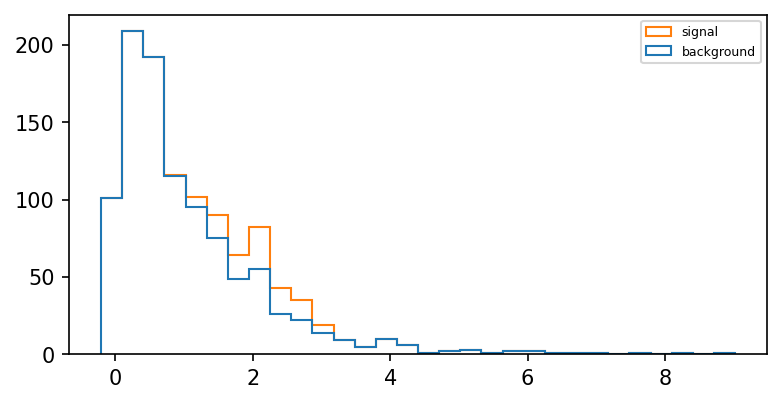

In [39]:
import jax
import jax.numpy as jnp
import numpy as np
from jax.random import PRNGKey
import matplotlib.pyplot as plt
import relaxed
from jaxopt import OptaxSolver
from optax import adam
from functools import partial

# matplotlib settings
plt.rc("figure", figsize=(6, 3), dpi=150, facecolor="w")
plt.rc("legend", fontsize=6)

# generate background data from an exponential distribution with a little noise
def generate_background(key, n_samples, n_features, noise_std):
    key, subkey = jax.random.split(key, 2)
    data = jax.random.exponential(subkey, (n_samples, n_features))
    key, subkey = jax.random.split(key, 2)
    data += jax.random.normal(subkey, (n_samples, n_features)) * noise_std
    return data


# generate signal data from a normal distribution close to the background
def generate_signal(key, n_samples, n_features):
    key, subkey = jax.random.split(key, 2)
    data = jax.random.normal(subkey, (n_samples, n_features)) / 2 + 2
    return data


# get 1000 samples from the background and 100 samples from the signal
bkg = generate_background(PRNGKey(0), 1000, 1, 0.1).ravel()
sig = generate_signal(PRNGKey(1), 100, 1).ravel()

plt.hist(
    [bkg, sig], stacked=True, bins=30, histtype="step", label=["background", "signal"]
)
plt.legend();

In [73]:
bins = jnp.linspace(0, 8, 5)


def pipe(bins, s, b, bandwidth=1e-2):
    # restrict bin edges so they don't overlap
    bins_new = jnp.concatenate(
        (
            jnp.array([bins[0]]),
            jnp.where(bins[1:] > bins[:-1], bins[1:], bins[:-1] + 1e-4),
        ),
        axis=0,
    )
    s_hist = relaxed.hist(s, bins=bins_new, bandwidth=bandwidth) + 1e-4
    b_hist = relaxed.hist(b, bins=bins_new, bandwidth=bandwidth) + 1e-4
    return 1 / relaxed.metrics.asimov_sig(s_hist, b_hist)


def hard_pipe(bins, s, b):
    s_hist = jnp.histogram(s, bins=bins)[0] + 1e-4
    b_hist = jnp.histogram(b, bins=bins)[0] + 1e-4
    return relaxed.metrics.asimov_sig(s_hist, b_hist)

/Users/phinate/code/relaxed/venv/lib/python3.9/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


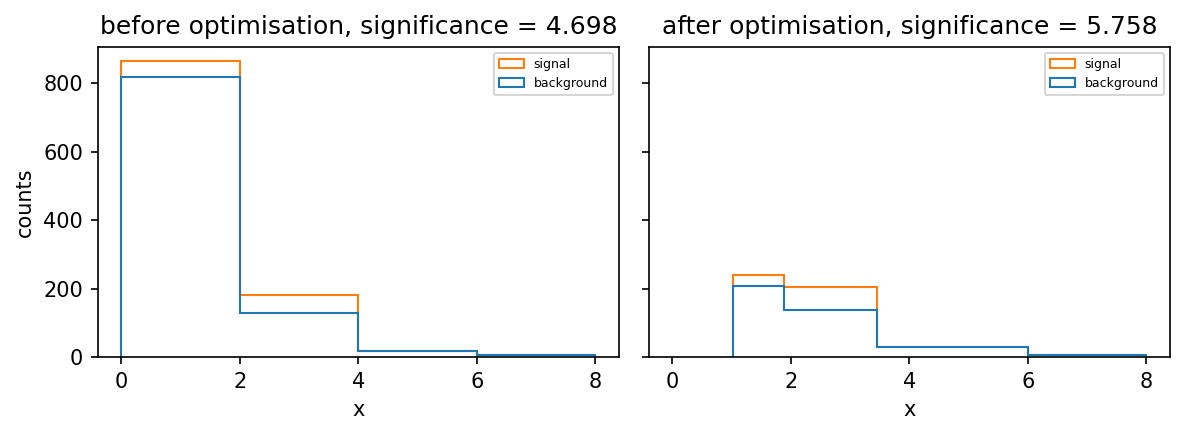

In [74]:
loss = partial(pipe, s=sig, b=bkg, bandwidth=1e-2)
solver = OptaxSolver(loss, adam(learning_rate=1e-2), maxiter=10000, tol=1e-6)
bins_opt = solver.run(bins).params
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)
ax = axs[1]
ax.hist(
    [bkg, sig],
    stacked=True,
    bins=bins_opt,
    histtype="step",
    label=["background", "signal"],
)
ax.legend()
ax.set_xlabel("x")
significance = hard_pipe(bins_opt, sig, bkg)
ax.set_title(f"after optimisation, significance = {significance:.3f}")

ax = axs[0]
ax.hist(
    [bkg, sig], stacked=True, bins=bins, histtype="step", label=["background", "signal"]
)
ax.legend()
ax.set_xlabel("x")
ax.set_ylabel("counts")
significance = hard_pipe(bins, sig, bkg)
ax.set_title(f"before optimisation, significance = {significance:.3f}")
plt.tight_layout()